In [2]:
!pip install datasets stanza

In [8]:
!pip install transformers

In [3]:
from datasets import load_dataset

dataset = load_dataset("Overfit-GM/turkish-toxic-language")

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

turkish_toxic_language.csv:   0%|          | 0.00/18.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/77800 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'target', 'source', 'is_toxic'],
        num_rows: 77800
    })
})

In [17]:
# ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# numpy and pandas for process and analyze
import pandas as pd
import numpy as np

# nltk for stopwords
from nltk.corpus import stopwords
import nltk

#re for clean special char
import re

# stanza for NLP preprocessing
!pip install stanza
import stanza

# sklearn libraries for models and evaulation metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# transformers libraries for NLP model training and evaluation
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# pytorch library for data handling, model training, and loss computation
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn import CrossEntropyLoss

# matpilotlib and seaborn libraries for visualize
import matplotlib.pyplot as plt
import seaborn as sns

# progress bar for data processing
from tqdm import tqdm

# install and download stanza's turkish model
stanza.download("tr", verbose=False)
print("Stanza Turkish model downloaded!")

nlp = stanza.Pipeline("tr", use_gpu=True)

print("Libraries and NLTK datasets loaded!")

Stanza Turkish model downloaded!
Libraries and NLTK datasets loaded!


In [5]:
nltk.download("stopwords")
stop_words = set(stopwords.words("turkish"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# function: remove special char
def remove_special_characters(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[\U00010000-\U0010FFFF]', '', text)
    return text

# preprocessing function
def preprocess_text_stanza(text):
    text = remove_special_characters(text.lower())

    doc = nlp(text)
    lemmatized_tokens = [
        word.lemma if word.lemma is not None else word.text
        for sentence in doc.sentences for word in sentence.words
        if word.text.isalpha() and word.text not in stop_words
    ]
    return " ".join(lemmatized_tokens)

tqdm.pandas()

train = dataset['train']
train = train.to_pandas()
train["cleaned_text"] = train["text"].progress_apply(preprocess_text_stanza)

train

100%|██████████| 77800/77800 [2:22:05<00:00,  9.13it/s]


,text,target,source,is_toxic,cleaned_text
0,Phil Spector bir lanet katil olduğunu Biliyors...,INSULT,jigsaw,1,phil spector bir lanet katil ol bil ben tıpkı ...
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,PROFANITY,told,1,la sik git amk pozitif sik kafa ülke ana dikil...
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0,ol iste ja rul bir tupac shakur ol iste çoğu z...
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0,yap gerek ara sonra sayfa bak gör kölelik din ...
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0,kabul dream chaser program ilgili ol çok kal m
...,...,...,...,...,...
77795,İsmi kısaltmak için her kutu kendi başına bir ...,OTHER,jigsaw,0,isim kısal kut kendi baş bir sayfa ol i zaten ...
77796,ecek acak 31 marta kadar incelenir gorusulur d...,OTHER,told,0,ecek i marta kadar incele goru dusun hazine ba...
77797,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,INSULT,jigsaw,1,oh adam sen sadece yumuşak bir inek saniye iç ...
77798,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,INSULT,jigsaw,1,zayıf site temizle


In [7]:
X = train["cleaned_text"]
y = train["is_toxic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(train.isnull().sum())

text            0
target          0
source          0
is_toxic        0
cleaned_text    0
dtype: int64


In [11]:
# we use a pre-trained bert model
model_name = "dbmdz/bert-base-turkish-cased"

# tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# datasets preparation
train_dataset = ToxicDataset(X_train, y_train, tokenizer)
test_dataset = ToxicDataset(X_test, y_test, tokenizer)

# training settings
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1,
)

# trainer (Hugging Face Trainer API)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.106700,0.133311
2,0.097000,0.171483
3,0.009500,0.210876


TrainOutput(global_step=11670, training_loss=0.11710236265540327, metrics={'train_runtime': 1199.0387, 'train_samples_per_second': 155.725, 'train_steps_per_second': 9.733, 'total_flos': 1.22820240642048e+16, 'train_loss': 0.11710236265540327, 'epoch': 3.0})

In [13]:
# which epoch is used
best_checkpoint = trainer.state.best_model_checkpoint
checkpoint_step = int(re.search(r"checkpoint-(\d+)", best_checkpoint).group(1))
total_training_steps = len(train_dataset) // training_args.per_device_train_batch_size
steps_per_epoch = total_training_steps // training_args.num_train_epochs
epoch_used = checkpoint_step / steps_per_epoch
print(f"Best model is from epoch: {epoch_used:.2f}")

Best model is from epoch: 3.00


Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.94      0.96      0.95      7580
       Toxic       0.96      0.94      0.95      7980

    accuracy                           0.95     15560
   macro avg       0.95      0.95      0.95     15560
weighted avg       0.95      0.95      0.95     15560



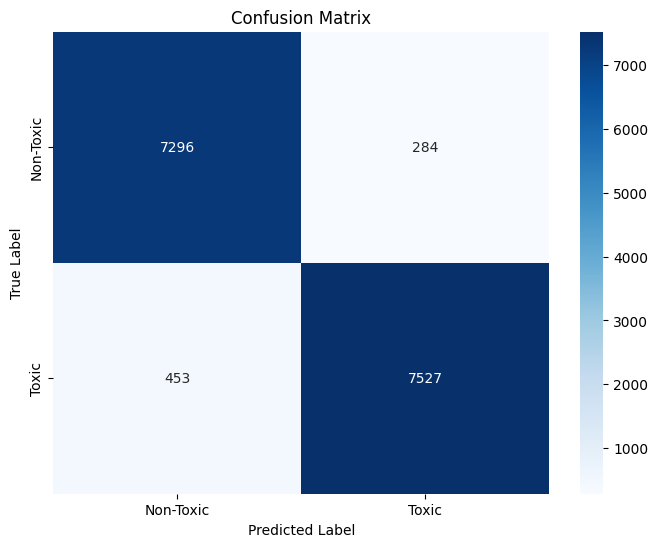

In [12]:
# classification report


predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

# performance metrics
print("Classification Report:")
print(classification_report(y_test, predicted_labels, target_names=["Non-Toxic", "Toxic"]))

# confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Toxic", "Toxic"], yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# target column for categorization model
X_category = train["cleaned_text"]
y_category = train["target"]

# convert categories in `target` column to numeric values
label_encoder = LabelEncoder()
y_category = label_encoder.fit_transform(y_category)

# compute class weights for imbalanced dataset
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_category),
    y=y_category
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# separate training and test sets
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_category, y_category, test_size=0.2, random_state=42
)

# tokenizer & model
category_tokenizer = AutoTokenizer.from_pretrained(model_name)
category_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

class CategoryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# datasets preparation
train_dataset_cat = CategoryDataset(X_train_cat, y_train_cat, category_tokenizer)
test_dataset_cat = CategoryDataset(X_test_cat, y_test_cat, category_tokenizer)

# custom trainer class for loss function with class weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# training settings
training_args_cat = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.1,
    gradient_accumulation_steps=2,
    logging_dir="./logs",
    report_to="none",
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1,
)

# trainer (Hugging Face Trainer API)
category_trainer = CustomTrainer(
    model=category_model,
    args=training_args_cat,
    train_dataset=train_dataset_cat,
    eval_dataset=test_dataset_cat,
    tokenizer=category_tokenizer,
)

category_trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.774600,0.381405
2,0.526200,0.354100
3,0.536000,0.364126
4,0.299500,0.405727


TrainOutput(global_step=4860, training_loss=0.6242393637390293, metrics={'train_runtime': 1763.3972, 'train_samples_per_second': 176.478, 'train_steps_per_second': 2.756, 'total_flos': 2.045164697744179e+16, 'train_loss': 0.6242393637390293, 'epoch': 4.995372750642673})

In [24]:
# which epoch is used for categorization model
best_checkpoint = category_trainer.state.best_model_checkpoint
checkpoint_step = int(re.search(r"checkpoint-(\d+)", best_checkpoint).group(1))
total_training_steps = len(train_dataset_cat) // training_args_cat.per_device_train_batch_size
steps_per_epoch = total_training_steps // training_args_cat.num_train_epochs
epoch_used = checkpoint_step / steps_per_epoch
print(f"Best model for categorization is from epoch: {epoch_used:.2f}")

Best model for categorization is from epoch: 5.00


Classification Report for Categorization Model:
              precision    recall  f1-score   support

      INSULT       0.75      0.79      0.77      2113
       OTHER       0.97      0.90      0.93      7580
   PROFANITY       0.92      0.92      0.92      3631
      RACIST       0.84      0.90      0.87      2012
      SEXIST       0.42      0.87      0.56       224

    accuracy                           0.89     15560
   macro avg       0.78      0.88      0.81     15560
weighted avg       0.90      0.89      0.90     15560



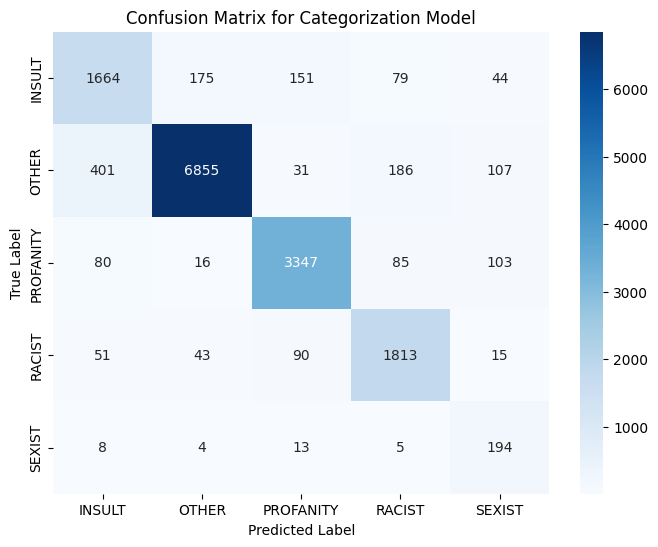

In [25]:
# classification report for categorization model

predictions = category_trainer.predict(test_dataset_cat)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

# performance metrics
print("Classification Report for Categorization Model:")
print(classification_report(
    y_test_cat,
    predicted_labels.numpy(),
    target_names=label_encoder.classes_
))

# confusion matrix
conf_matrix = confusion_matrix(y_test_cat, predicted_labels.numpy())

# visualization of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Categorization Model")
plt.show()